In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

print(f"TensorFlow version = {tf.__version__}\n")

SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data from all CSV files
classes = []
inputs = []
outputs = []

TensorFlow version = 2.15.0



In [2]:
for file in os.listdir("/content/"):
    if file.endswith(".csv"):
        objectClass = os.path.splitext(file)[0]
        classes.append(objectClass)
        df = pd.read_csv("/content/" + file)
        df = df.dropna().reset_index(drop=True)
        inputs.extend(df[['Red', 'Green', 'Blue']].values)
        outputs.extend([objectClass] * len(df))

In [3]:
class_encoder = {cls: i for i, cls in enumerate(classes)}
encoded_outputs = np.array([class_encoder[cls] for cls in outputs])

randomize = np.arange(len(inputs))
np.random.shuffle(randomize)
inputs = np.array(inputs)[randomize]
encoded_outputs = encoded_outputs[randomize]

In [47]:
num_classes=len(classes)
train_split = int(0.7 * len(inputs))
val_split = int(0.15 * len(inputs)) + train_split
inputs_train, inputs_val, inputs_test = np.split(inputs, [train_split, val_split])
outputs_train, outputs_val, outputs_test = np.split(encoded_outputs, [train_split, val_split])

# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 128)               512       
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 2)                 66        
                                                                 
Total params: 10914 (42.63 KB)
Trainable params: 10914 (42.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=32, validation_data=(inputs_val, outputs_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(inputs_test, outputs_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/100
59/59 [==============================] - 2s 9ms/step - loss: 0.4991 - accuracy: 0.8340 - val_loss: 0.3012 - val_accuracy: 0.8772
Epoch 2/100
59/59 [==============================] - 0s 5ms/step - loss: 0.2744 - accuracy: 0.8883 - val_loss: 0.2235 - val_accuracy: 0.9098
Epoch 3/100
59/59 [==============================] - 0s 5ms/step - loss: 0.2609 - accuracy: 0.9012 - val_loss: 0.2298 - val_accuracy: 0.9123
Epoch 4/100
59/59 [==============================] - 0s 6ms/step - loss: 0.2568 - accuracy: 0.9033 - val_loss: 0.2831 - val_accuracy: 0.8847
Epoch 5/100
59/59 [==============================] - 0s 5ms/step - loss: 0.2553 - accuracy: 0.9028 - val_loss: 0.2190 - val_accuracy: 0.9198
Epoch 6/100
59/59 [==============================] - 0s 4ms/step - loss: 0.2490 - accuracy: 0.9162 - val_loss: 0.2086 - val_accuracy: 0.9198
Epoch 7/100
59/59 [==============================] - 0s 6ms/step - loss: 0.2521 - accuracy: 0.9108 - val_loss: 0.2106 - val_accuracy: 0.9248
Epoch 8/100
5

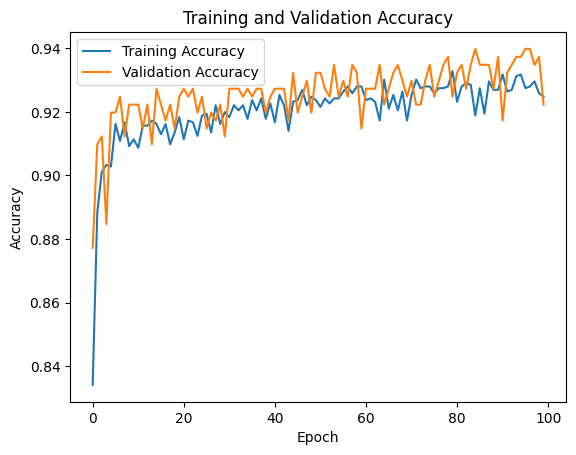

In [51]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

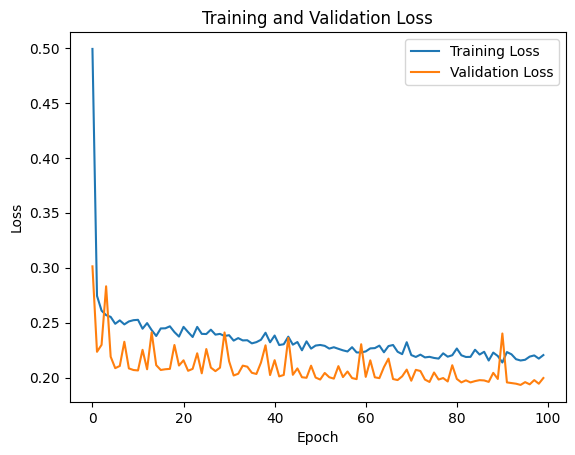

In [52]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open("colour_model.tflite","wb").write(tflite_model)

basic_model_size = os.path.getsize("colour_model.tflite")

print("Model is %d bytes"%basic_model_size)

Model is 11720 bytes


In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat colour_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h


model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,}bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 72,234bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
